In [135]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

BASE_PATH = Path(r"D:\Harrison\cells\mdck_analysis\barspeeds")

track_path = BASE_PATH / "tracks"
save_path = BASE_PATH / "figures"

In [136]:
tracks = {}
stems = []
files = []

for f in track_path.glob("*.csv"):
    files.append(f)
    stems.append(f.stem)
    tracks[f.stem] = pd.read_csv(f)



In [137]:
px_um = 1.33
frame_min = 5
img_shape = (800, 800)

for df in tracks.values():

    df["px_x_centered"] = df["px_x"] - img_shape[1] / 2
    df["px_y_centered"] = df["px_y"] - img_shape[0] / 2

    df["um_x"] = df["px_x"] * px_um
    df["um_y"] = df["px_y"] * px_um

    df["um_x_centered"] = df["px_x_centered"] * px_um
    df["um_y_centered"] = df["px_y_centered"] * px_um

    df["time"] = df["frame"] * frame_min

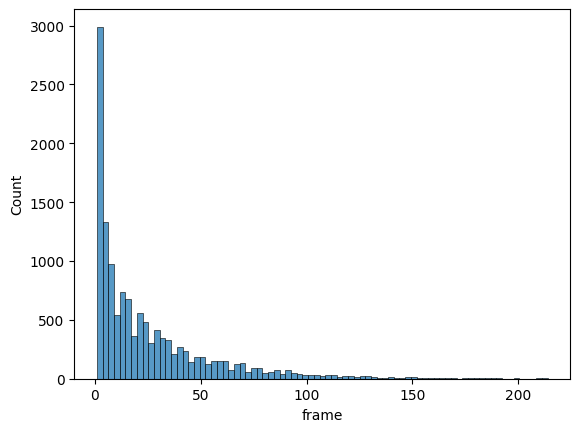

In [9]:

df = tracks[stems[0]]

sns.histplot(x=df.groupby("track_id")["frame"].count())
plt.show()


bar175.20k.01_channel_545_patterns_tracks


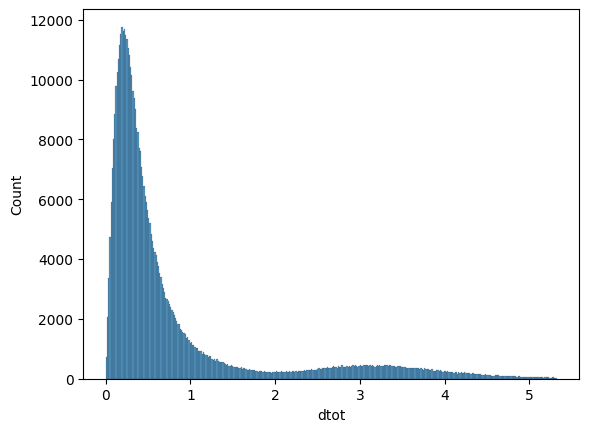

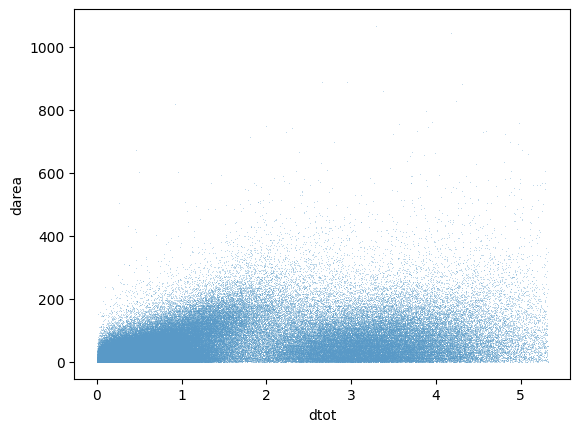

In [48]:
k = 13

print(stems[k])
df = tracks[stems[k]]

df["dx"] = df.groupby("track_id")["um_x"].diff() / frame_min
df["dy"] = df.groupby("track_id")["um_y"].diff() / frame_min
df["dtot"] = np.sqrt(df["dx"] ** 2 + df["dy"] ** 2)
df["darea"] = df.groupby("track_id")["area"].diff().abs()

# sns.histplot(x=df["dx"], label="dx")
# sns.histplot(x=df["dy"], label="dy")
#
# print(df["dx"].mean())
# print(df["dy"].mean())
# plt.legend()
# plt.show()

sns.histplot(x=df["dtot"])
plt.show()

sns.scatterplot(df, x="dtot", y="darea", s=0.2)
plt.show()

bar10.20k.01_channel_545_patterns_tracks
123078


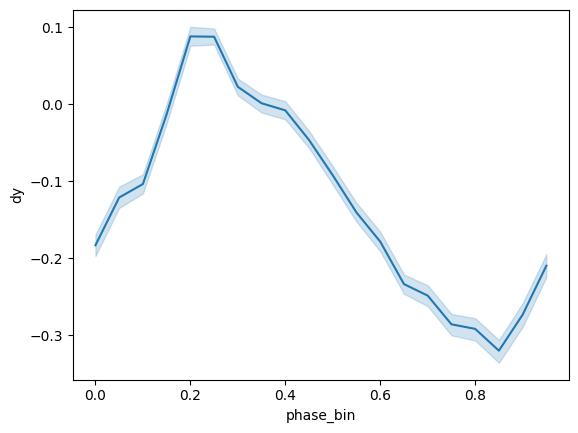

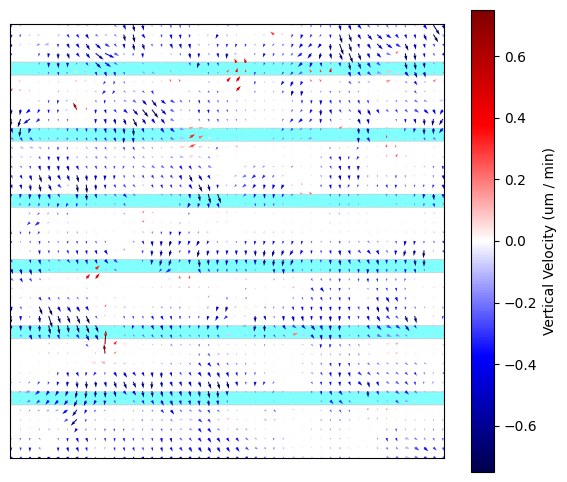

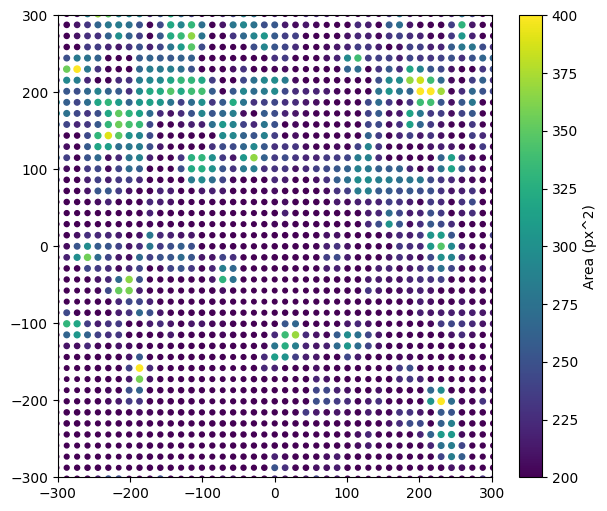

In [150]:
from scipy.spatial.distance import cdist
import tifffile

k = 13

n_samples = 75
time = 900
time_limit = 7.5
sigma = 10

print(stems[k])
df = tracks[stems[k]]

df["dx"] = df.groupby("track_id")["um_x"].diff() / frame_min
df["dy"] = df.groupby("track_id")["um_y"].diff() / frame_min
df["dtot"] = np.sqrt(df["dx"] ** 2 + df["dy"] ** 2)

if stems[k] == "dark":
    bar_speed = 0
    df["phase"] = 0
elif stems[k] == "down":
    bar_speed = -1
    df["phase"] = 0
else:
    bar_speed_str = stems[k].split(".")[0][3:]
    bar_speed = int(bar_speed_str) / (10**(len(bar_speed_str) - 1))
    period_time = 100 / bar_speed

    df["phase"] = ((df["time"] - (df["um_y"] / bar_speed)) % (period_time)) / period_time

df_cropped = df[df["time"].between(180, 900) &
                df["px_x"].between(150, 650) &
                df["px_y"].between(150, 650) &
                (df["dtot"] < 2) &
                (~df["dx"].isna()) &
                (~df["dy"].isna())].copy()

print(len(df_cropped))

df_cropped["phase_bin"] = (df_cropped["phase"] // 0.05) * 0.05

sns.lineplot(df_cropped, x="phase_bin", y="dy")
plt.show()

# get data points near time, filter out bad tracks
df = df[(df["time"] - time).abs() < time_limit]
df = df[~df["dx"].isna()]
df = df[~df["dy"].isna()]
df = df[df["dtot"] < 2].copy()

# get sampling positions in image coordinates and um coordinates
ax = np.linspace(-img_shape[1] / 2, img_shape[1] / 2, n_samples) * px_um
ay = np.linspace(-img_shape[0] / 2, img_shape[0] / 2, n_samples) * px_um

px_x = np.linspace(0, img_shape[1], n_samples)
px_y = np.linspace(0, img_shape[0], n_samples)

xx, yy = np.meshgrid(ax, ay)
X = np.array([xx.flatten(), yy.flatten()]).T

px_xx, px_yy = np.meshgrid(px_x, px_y)
X_px = np.array([px_xx.flatten(), px_yy.flatten()])

# get dxdy at sample positions using gaussian kernels
pos = df[["um_x_centered", "um_y_centered"]].values
distances = cdist(X, pos)
weights = np.exp(-0.5 * np.square(distances) / np.square(sigma))

dx_weighted = np.mean(weights * df["dx"].values[None, :], axis=1) / np.mean(weights, axis=1)
dy_weighted = np.mean(weights * df["dy"].values[None, :], axis=1) / np.mean(weights, axis=1)
area_weighted = np.mean(weights * df["area"].values[None, :], axis=1) / np.mean(weights, axis=1)


fig, ax = plt.subplots(figsize=(7, 6))

# show light bars
frame_data, frame_pattern = tifffile.imread(BASE_PATH / f"{stems[k][:-7]}.tif")[int(time // time_limit)]
ax.imshow(np.stack([np.zeros_like(frame_pattern), frame_pattern, frame_pattern, frame_pattern // 2], axis=-1))

# plot velocities
q = ax.quiver(X_px[0], X_px[1], dx_weighted, dy_weighted, dy_weighted, cmap="seismic", scale_units="xy", clim=(-0.75, 0.75))
cbar = fig.colorbar(q, ax=ax, orientation='vertical')
cbar.set_label('Vertical Velocity (um / min)')


ax.set_xlim(150, 650)
ax.set_ylim(150, 650)
ax.set_xticks([])
ax.set_yticks([])

plt.savefig(save_path / f"local_movement_{stems[k]}.png", dpi=300)
plt.show()

# scatterplot of colors
fig, ax = plt.subplots(figsize=(7, 6))
q = ax.scatter(X[:, 0], X[:, 1], s=np.sqrt(area_weighted), c=area_weighted, cmap="viridis", clim=(200, 400))
cbar = fig.colorbar(q, ax=ax, orientation='vertical')
cbar.set_label('Area (px^2)')


ax.set_xlim(-300, 300)
ax.set_ylim(-300, 300)

plt.savefig(save_path / f"local_movement_scatter_{stems[k]}.png", dpi=300)

plt.show()


bar025.10k2.02_channel_545_patterns_tracks
115490
bar025.10k2.03_channel_545_patterns_tracks
115000
bar025.20k.00_channel_545_patterns_tracks
129248
bar025.20k.01_channel_545_patterns_tracks
126359
bar05.10k2.02_channel_545_patterns_tracks
113251
bar05.10k2.03_channel_545_patterns_tracks
103853
bar05.20k.00_channel_545_patterns_tracks
123617
bar05.20k.01_channel_545_patterns_tracks
145517
bar075.10k2.02_channel_545_patterns_tracks
119119
bar075.10k2.03_channel_545_patterns_tracks
119536
bar075.20k.00_channel_545_patterns_tracks
110712
bar075.20k.01_channel_545_patterns_tracks
138942
bar10.10k.00_channel_545_patterns_tracks
92292
bar10.20k.01_channel_545_patterns_tracks
123078
bar10.20k2.02_channel_545_patterns_tracks
150926
bar10.20k2.03_channel_545_patterns_tracks
144702
bar125.10k.00_channel_545_patterns_tracks
93346
bar125.20k.01_channel_545_patterns_tracks
119590
bar125.20k2.02_channel_545_patterns_tracks
142229
bar125.20k2.03_channel_545_patterns_tracks
148362
bar15.10k.00_channel

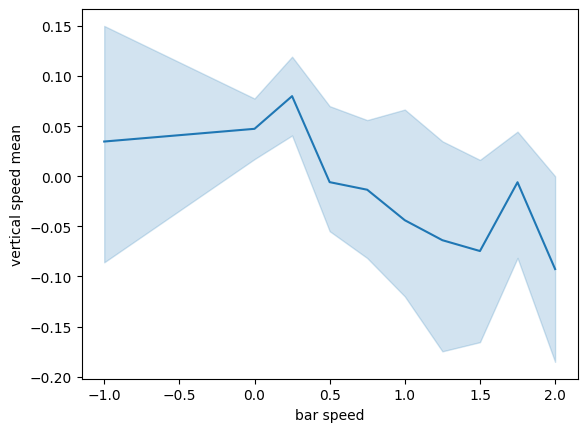

In [144]:
from collections import defaultdict

data = defaultdict(list)

for k in range(len(stems)):

    n_samples = 75
    time = 900
    time_limit = 7.5
    sigma = 10

    print(stems[k])
    df = tracks[stems[k]]

    df["dx"] = df.groupby("track_id")["um_x"].diff() / frame_min
    df["dy"] = df.groupby("track_id")["um_y"].diff() / frame_min
    df["dtot"] = np.sqrt(df["dx"] ** 2 + df["dy"] ** 2)

    if stems[k].split(".")[0] == "dark":
        bar_speed = 0
        df["phase"] = 0
    elif stems[k].split(".")[0] == "down":
        bar_speed = -1
        df["phase"] = 0
    else:
        bar_speed_str = stems[k].split(".")[0][3:]
        bar_speed = int(bar_speed_str) / (10**(len(bar_speed_str) - 1))
        period_time = 100 / bar_speed

    df["phase"] = ((df["time"] - (df["um_y"] / bar_speed)) % (period_time)) / period_time

    df_cropped = df[df["time"].between(180, 900) &
                    df["px_x"].between(150, 650) &
                    df["px_y"].between(150, 650) &
                    (df["dtot"] < 2) &
                    (~df["dx"].isna()) &
                    (~df["dy"].isna())].copy()

    print(len(df_cropped))

    df_cropped["phase_bin"] = (df_cropped["phase"] // 0.05) * 0.05

    # sns.lineplot(df_cropped, x="phase_bin", y="dy", label=bar_speed)

    data["vertical speed mean"].append(df_cropped["dy"].mean())
    data["bar speed"].append(bar_speed)

speed_data = pd.DataFrame(data)
sns.lineplot(speed_data, x="bar speed", y="vertical speed mean")
plt.show()